In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

# Financial services data
financial_services_data = {
    'Product': [
        'Credit card', 'Credit card or prepaid card', 'Prepaid card',
        'Consumer Loan', 'Mortgage', 'Payday loan',
        'Payday loan, title loan, or personal loan', 'Student loan',
        'Vehicle loan or lease', 'Bank account or service',
        'Checking or savings account', 'Credit reporting',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Debt collection', 'Money transfer, virtual currency, or money service',
        'Money transfers', 'Other financial service'
    ]
}

# Generate embeddings
print("Loading model and generating embeddings...")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(financial_services_data['Product'])
print(f"Embeddings shape: {embeddings.shape}")

# Test range for clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# =============================================================================
# K-MEANS CLUSTERING ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*50)

kmeans_silhouette_scores = []
kmeans_results = {}

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    kmeans_silhouette_scores.append(silhouette_avg)
    kmeans_results[n_clusters] = {
        'labels': cluster_labels,
        'silhouette': silhouette_avg,
        'model': kmeans
    }

    print(f"K-means k={n_clusters}: Silhouette Score = {silhouette_avg:.3f}")

kmeans_optimal_k = range_n_clusters[np.argmax(kmeans_silhouette_scores)]
kmeans_best_score = max(kmeans_silhouette_scores)
print(f"\nK-means Optimal k: {kmeans_optimal_k}, Best Score: {kmeans_best_score:.3f}")

# =============================================================================
# HIERARCHICAL CLUSTERING ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("HIERARCHICAL CLUSTERING ANALYSIS")
print("="*50)

# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_results = {}

for method in linkage_methods:
    print(f"\nTesting {method} linkage...")
    silhouette_scores = []
    method_results = {}

    for n_clusters in range_n_clusters:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        cluster_labels = agglo.fit_predict(embeddings)

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        method_results[n_clusters] = {
            'labels': cluster_labels,
            'silhouette': silhouette_avg
        }

        print(f"  k={n_clusters}: Silhouette Score = {silhouette_avg:.3f}")

    best_k = range_n_clusters[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)

    hierarchical_results[method] = {
        'scores': silhouette_scores,
        'best_k': best_k,
        'best_score': best_score,
        'results': method_results
    }

    print(f"  Best k={best_k}, Score={best_score:.3f}")

# Find overall best hierarchical method
best_hierarchical_method = max(hierarchical_results.keys(),
                              key=lambda x: hierarchical_results[x]['best_score'])
hierarchical_optimal_k = hierarchical_results[best_hierarchical_method]['best_k']
hierarchical_best_score = hierarchical_results[best_hierarchical_method]['best_score']

print(f"\nBest Hierarchical: {best_hierarchical_method} linkage")
print(f"Optimal k: {hierarchical_optimal_k}, Best Score: {hierarchical_best_score:.3f}")

# =============================================================================
# COMPARISON AND FINAL ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("METHOD COMPARISON")
print("="*50)

print(f"K-means:      k={kmeans_optimal_k}, Score={kmeans_best_score:.3f}")
print(f"Hierarchical: k={hierarchical_optimal_k}, Score={hierarchical_best_score:.3f} ({best_hierarchical_method})")

# Choose the better method
if hierarchical_best_score > kmeans_best_score:
    print(f"\n✓ Hierarchical clustering performs better (+{hierarchical_best_score - kmeans_best_score:.3f})")
    final_method = "hierarchical"
    final_k = hierarchical_optimal_k
    final_labels = hierarchical_results[best_hierarchical_method]['results'][hierarchical_optimal_k]['labels']
    final_score = hierarchical_best_score
else:
    print(f"\n✓ K-means clustering performs better (+{kmeans_best_score - hierarchical_best_score:.3f})")
    final_method = "k-means"
    final_k = kmeans_optimal_k
    final_labels = kmeans_results[kmeans_optimal_k]['labels']
    final_score = kmeans_best_score

# =============================================================================
# DETAILED CLUSTER ANALYSIS
# =============================================================================
print(f"\n" + "="*50)
print(f"FINAL CLUSTERING RESULTS ({final_method.upper()})")
print("="*50)

# Create results dataframe
results_df = pd.DataFrame({
    'Product': financial_services_data['Product'],
    'Cluster': final_labels
})

# Calculate individual silhouette scores
sample_silhouette_values = silhouette_samples(embeddings, final_labels)
results_df['Silhouette_Score'] = sample_silhouette_values

print(f"Method: {final_method}")
if final_method == "hierarchical":
    print(f"Linkage: {best_hierarchical_method}")
print(f"Number of clusters: {final_k}")
print(f"Overall silhouette score: {final_score:.3f}")

print(f"\nCluster breakdown:")
for cluster_id in range(final_k):
    cluster_products = results_df[results_df['Cluster'] == cluster_id]
    avg_silhouette = cluster_products['Silhouette_Score'].mean()

    print(f"\nCluster {cluster_id} (Size: {len(cluster_products)}, Avg Silhouette: {avg_silhouette:.3f}):")
    for _, row in cluster_products.iterrows():
        print(f"  - {row['Product']} (Score: {row['Silhouette_Score']:.3f})")

# =============================================================================
# VISUALIZATION
# =============================================================================
print(f"\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# 1. Silhouette score comparison plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, kmeans_silhouette_scores, 'o-', label='K-means', linewidth=2)
for method in linkage_methods:
    plt.plot(range_n_clusters, hierarchical_results[method]['scores'],
             's--', label=f'Hierarchical ({method})', alpha=0.7)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clustering Method Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. PCA visualization of final clustering
plt.subplot(1, 2, 2)
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

colors = plt.cm.Set1(np.linspace(0, 1, final_k))
for i in range(final_k):
    cluster_points = embeddings_2d[final_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=100)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Final Clustering Visualization\n({final_method}, k={final_k})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Dendrogram for hierarchical clustering (if it's the winner)
if final_method == "hierarchical":
    plt.figure(figsize=(15, 8))
    Z = linkage(embeddings, method=best_hierarchical_method)
    dendrogram(
        Z,
        labels=financial_services_data['Product'],
        leaf_rotation=45,
        leaf_font_size=10
    )
    plt.title(f'Hierarchical Clustering Dendrogram ({best_hierarchical_method.capitalize()} Linkage)')
    plt.xlabel('Financial Products')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

print("Analysis complete!")


Loading model and generating embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (17, 384)

K-MEANS CLUSTERING ANALYSIS
K-means k=2: Silhouette Score = 0.089
K-means k=3: Silhouette Score = 0.111
K-means k=4: Silhouette Score = 0.136
K-means k=5: Silhouette Score = 0.150
K-means k=6: Silhouette Score = 0.154
K-means k=7: Silhouette Score = 0.153
K-means k=8: Silhouette Score = 0.163
K-means k=9: Silhouette Score = 0.153
K-means k=10: Silhouette Score = 0.155

K-means Optimal k: 8, Best Score: 0.163

HIERARCHICAL CLUSTERING ANALYSIS

Testing ward linkage...
  k=2: Silhouette Score = 0.088
  k=3: Silhouette Score = 0.124
  k=4: Silhouette Score = 0.159
  k=5: Silhouette Score = 0.158
  k=6: Silhouette Score = 0.157
  k=7: Silhouette Score = 0.156
  k=8: Silhouette Score = 0.163
  k=9: Silhouette Score = 0.162
  k=10: Silhouette Score = 0.156
  Best k=8, Score=0.163

Testing complete linkage...
  k=2: Silhouette Score = 0.095
  k=3: Silhouette Score = 0.116
  k=4: Silhouette Score = 0.129
  k=5: Silhouette Score = 0.115
  k=6: Silhouette Score = 0.15

Analysis complete!


In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

class FixedUMBankClassifier:

    def __init__(self, csv_file_path='/content/cleaned_UMBank_complaints_data.csv'):
        self.csv_file_path = csv_file_path
        self.df = None
        self.volume_tiers = {}
        self.groups = {}

    def load_and_prepare_data(self):
        """Load and prepare the full dataset"""
        print("FIXED UMBANK CLASSIFIER - FULL DATASET")
        print("=" * 60)
        print(f"Loading data from: {self.csv_file_path}")

        try:
            self.df = pd.read_csv(self.csv_file_path, encoding='utf-8')
            print(f"Successfully loaded: {self.df.shape}")
            print(f"Total complaints: {len(self.df):,}")

            required_columns = ['Product', 'Sub-product', 'Issue', 'Sub-issue']
            missing_cols = [col for col in required_columns if col not in self.df.columns]

            if missing_cols:
                print(f"Missing columns: {missing_cols}")
                return None

            print(f"All required columns present: {required_columns}")

            print(f"\nACTUAL PRODUCT DISTRIBUTION:")
            product_counts = self.df['Product'].value_counts()
            for product, count in product_counts.items():
                print(f"  {product}: {count:,} complaints")

            print(f"\nTotal analyzed: {product_counts.sum():,} complaints")

            return self.df

        except Exception as e:
            print(f"Error loading data: {e}")
            return None

    def analyze_full_dataset_patterns(self):
        """Analyze patterns in the full dataset"""
        print(f"\n" + "=" * 60)
        print("FULL DATASET PATTERN ANALYSIS")
        print("=" * 60)

        product_volumes = self.df['Product'].value_counts()
        total_complaints = product_volumes.sum()

        print(f"Dataset Summary:")
        print(f"  Total complaints: {total_complaints:,}")
        print(f"  Unique products: {len(product_volumes)}")
        print(f"  Date range: {self.df['Date_received'].min()} to {self.df['Date_received'].max()}")

        volumes = product_volumes.values
        high_threshold = np.percentile(volumes, 75)  # Top 25%
        medium_threshold = np.percentile(volumes, 40)  # Middle

        print(f"\nVolume Tier Analysis:")
        print(f"  High volume threshold: >{high_threshold:.0f} complaints")
        print(f"  Medium volume threshold: {medium_threshold:.0f}-{high_threshold:.0f} complaints")
        print(f"  Low volume threshold: <{medium_threshold:.0f} complaints")

        self.volume_tiers = {
            'high': product_volumes[product_volumes > high_threshold].index.tolist(),
            'medium': product_volumes[(product_volumes >= medium_threshold) &
                                    (product_volumes <= high_threshold)].index.tolist(),
            'low': product_volumes[product_volumes < medium_threshold].index.tolist()
        }

        for tier, products in self.volume_tiers.items():
            tier_complaints = sum(product_volumes[p] for p in products)
            print(f"\n  {tier.title()} volume products ({len(products)} products, {tier_complaints:,} complaints):")
            for product in products:
                print(f"    • {product}: {product_volumes[product]:,}")

        return product_volumes

    def analyze_issue_complexity(self):
        """Analyze issue complexity across products"""
        print(f"\n" + "=" * 60)
        print("ISSUE COMPLEXITY ANALYSIS")
        print("=" * 60)

        product_issue_analysis = {}

        for product in self.df['Product'].unique():
            product_data = self.df[self.df['Product'] == product]

            issue_dist = product_data['Issue'].value_counts(normalize=True)

            issue_entropy = -sum(p * np.log2(p) for p in issue_dist if p > 0)
            max_entropy = np.log2(len(issue_dist)) if len(issue_dist) > 0 else 1
            complexity_score = issue_entropy / max_entropy if max_entropy > 0 else 0

            product_issue_analysis[product] = {
                'total_complaints': len(product_data),
                'unique_issues': len(issue_dist),
                'top_issue': issue_dist.index[0],
                'top_issue_pct': issue_dist.iloc[0],
                'complexity_score': complexity_score,
                'issue_diversity': len(issue_dist) / len(product_data)
            }

            print(f"\n{product} ({len(product_data):,} complaints):")
            print(f"  Unique issues: {len(issue_dist)}")
            print(f"  Top issue: {issue_dist.index[0]} ({issue_dist.iloc[0]:.1%})")
            print(f"  Complexity score: {complexity_score:.3f}")

        return product_issue_analysis

    def create_strategic_groups(self, product_volumes, issue_analysis):
        """Create strategic groups based on volume and business logic"""
        print(f"\n" + "=" * 60)
        print("STRATEGIC GROUP CREATION")
        print("=" * 60)

        strategic_groups = {
            1: {
                'name': 'High-Volume Consumer Products',
                'description': 'Mass market products requiring dedicated teams',
                'products': [],
                'strategy': 'Dedicated high-capacity teams with streamlined processes'
            },
            2: {
                'name': 'Credit & Lending Portfolio',
                'description': 'All credit and loan products',
                'products': [],
                'strategy': 'Specialized lending team with risk management focus'
            },
            3: {
                'name': 'Core Banking Services',
                'description': 'Basic banking and account services',
                'products': [],
                'strategy': 'Core banking team with operational excellence focus'
            },
            4: {
                'name': 'Regulatory & Collections',
                'description': 'High-compliance and debt management products',
                'products': [],
                'strategy': 'Compliance-focused team with legal support'
            },
            5: {
                'name': 'Specialized Services',
                'description': 'Payment services and other financial products',
                'products': [],
                'strategy': 'Technical specialists for transaction-based services'
            }
        }

        for product in product_volumes.index:
            volume = product_volumes[product]
            product_lower = product.lower()
            complexity = issue_analysis[product]['complexity_score']

            # Group 1: High-volume consumer products (top tier)
            if product in self.volume_tiers['high']:
                strategic_groups[1]['products'].append(product)

            # Group 4: Regulatory and compliance (debt collection, credit reporting)
            elif any(keyword in product_lower for keyword in ['debt collection', 'credit reporting']):
                strategic_groups[4]['products'].append(product)

            # Group 2: Credit & Lending products
            elif any(keyword in product_lower for keyword in ['credit card', 'loan', 'mortgage']):
                strategic_groups[2]['products'].append(product)

            # Group 3: Core banking products
            elif any(keyword in product_lower for keyword in ['account', 'checking', 'savings', 'bank']):
                strategic_groups[3]['products'].append(product)

            # Group 5: Specialized services (everything else)
            else:
                strategic_groups[5]['products'].append(product)

        strategic_groups = self._validate_strategic_groups(strategic_groups, product_volumes)

        self.groups = strategic_groups
        return strategic_groups

    def _validate_strategic_groups(self, groups, product_volumes):
        """Validate and balance the strategic groups"""
        print(f"\nValidating strategic groups...")

        empty_groups = [gid for gid, info in groups.items() if not info['products']]
        if empty_groups:
            print(f"⚠️ Empty groups found: {empty_groups}")

        single_product_groups = [gid for gid, info in groups.items() if len(info['products']) == 1]

        for group_id in single_product_groups:
            product = groups[group_id]['products'][0]
            product_lower = product.lower()

            if 'card' in product_lower and 2 in groups:
                groups[2]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 2 (Credit & Lending)")
            elif 'account' in product_lower and 3 in groups:
                groups[3]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 3 (Banking)")
            elif 'transfer' in product_lower and 5 in groups:
                groups[5]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 5 (Specialized)")

        non_empty_groups = {gid: info for gid, info in groups.items() if info['products']}

        final_groups = {}
        for new_id, (old_id, info) in enumerate(non_empty_groups.items(), 1):
            final_groups[new_id] = info

        return final_groups

    def validate_final_classification(self, groups, product_volumes):
        """Validate the final classification"""
        print(f"\n" + "=" * 60)
        print("FINAL CLASSIFICATION VALIDATION")
        print("=" * 60)

        validation_results = {}
        total_complaints_classified = 0

        for group_id, group_info in groups.items():
            if not group_info['products']:
                continue

            group_volumes = [product_volumes[p] for p in group_info['products']]
            total_complaints = sum(group_volumes)
            total_complaints_classified += total_complaints

            max_vol = max(group_volumes)
            min_vol = min(group_volumes)
            volume_ratio = max_vol / min_vol if min_vol > 0 else 1

            group_data = self.df[self.df['Product'].isin(group_info['products'])]
            issue_distribution = group_data['Issue'].value_counts(normalize=True)

            entropy = -sum(p * np.log2(p) for p in issue_distribution if p > 0)
            max_entropy = np.log2(len(issue_distribution)) if len(issue_distribution) > 0 else 1
            consistency_score = 1 - (entropy / max_entropy) if max_entropy > 0 else 0

            issues = []
            if volume_ratio > 5:
                issues.append(f"Volume disparity: {volume_ratio:.1f}x")
            if consistency_score < 0.2:
                issues.append("Low issue consistency")

            validation_results[group_id] = {
                'total_complaints': total_complaints,
                'products_count': len(group_info['products']),
                'volume_ratio': volume_ratio,
                'consistency_score': consistency_score,
                'issues': issues,
                'avg_complaints_per_product': total_complaints / len(group_info['products'])
            }

            print(f"\n{group_info['name']} (Group {group_id}):")
            print(f"  Products ({len(group_info['products'])}): {', '.join(group_info['products'])}")
            print(f"  Total complaints: {total_complaints:,}")
            print(f"  Avg per product: {total_complaints / len(group_info['products']):.0f}")
            print(f"  Volume ratio: {volume_ratio:.1f}x")
            print(f"  Consistency score: {consistency_score:.3f}")
            print(f"  Issues: {issues if issues else 'None'}")
            print(f"  Strategy: {group_info['strategy']}")

        # Overall assessment
        print(f"\n" + "=" * 40)
        print(f"OVERALL ASSESSMENT")
        print(f"=" * 40)
        print(f"Total complaints classified: {total_complaints_classified:,}")
        print(f"Classification coverage: {total_complaints_classified / len(self.df) * 100:.1f}%")

        avg_consistency = np.mean([v['consistency_score'] for v in validation_results.values()])
        total_issues = sum(len(v['issues']) for v in validation_results.values())

        print(f"Average consistency score: {avg_consistency:.3f}")
        print(f"Total validation issues: {total_issues}")

        if avg_consistency > 0.15 and total_issues <= 2:
            print("EXCELLENT: Classification is well-balanced and effective")
        elif avg_consistency > 0.10 and total_issues <= 4:
            print("GOOD: Classification is acceptable with minor issues")
        else:
            print("⚠️ ACCEPTABLE: Classification works given data constraints")

        return validation_results

    def create_final_results(self, groups):
        """Create final results dataframe"""
        results_list = []

        for group_id, group_info in groups.items():
            for product in group_info['products']:
                product_complaints = len(self.df[self.df['Product'] == product])
                results_list.append({
                    'Product': product,
                    'Group_ID': group_id,
                    'Group_Name': group_info['name'],
                    'Group_Description': group_info['description'],
                    'Management_Strategy': group_info['strategy'],
                    'Complaint_Volume': product_complaints
                })

        results_df = pd.DataFrame(results_list)
        return results_df.sort_values(['Group_ID', 'Complaint_Volume'], ascending=[True, False])

    def run_complete_analysis(self):
        """Run the complete analysis on the full dataset"""
        print("RUNNING COMPLETE ANALYSIS ON FULL DATASET")
        print("=" * 60)

        if self.load_and_prepare_data() is None:
            return None, None, None

        product_volumes = self.analyze_full_dataset_patterns()

        issue_analysis = self.analyze_issue_complexity()

        groups = self.create_strategic_groups(product_volumes, issue_analysis)

        validation = self.validate_final_classification(groups, product_volumes)

        final_results = self.create_final_results(groups)

        print(f"\n" + "=" * 60)
        print("FINAL STRATEGIC CLASSIFICATION")
        print("=" * 60)
        print(final_results[['Product', 'Group_Name', 'Complaint_Volume']].to_string(index=False))

        return final_results, groups, validation

    def save_results(self, results, groups, validation):
        """Save all results to files"""
        print(f"\nSAVING RESULTS...")

        results_file = '/content/umbank_strategic_classification_FULL.csv'
        results.to_csv(results_file, index=False)
        print(f"Strategic classification saved: {results_file}")

        analysis_file = '/content/umbank_full_analysis_report.txt'
        with open(analysis_file, 'w') as f:
            f.write("UMBank Strategic Classification - Full Dataset Analysis\n")
            f.write("=" * 60 + "\n\n")

            f.write(f"DATASET SUMMARY:\n")
            f.write(f"Total complaints analyzed: {len(self.df):,}\n")
            f.write(f"Unique products: {self.df['Product'].nunique()}\n")
            f.write(f"Date range: {self.df['Date_received'].min()} to {self.df['Date_received'].max()}\n\n")

            f.write("STRATEGIC GROUPS:\n")
            for group_id, group_info in groups.items():
                total_complaints = sum(len(self.df[self.df['Product'] == p]) for p in group_info['products'])
                f.write(f"\nGroup {group_id}: {group_info['name']}\n")
                f.write(f"Description: {group_info['description']}\n")
                f.write(f"Strategy: {group_info['strategy']}\n")
                f.write(f"Products ({len(group_info['products'])}): {', '.join(group_info['products'])}\n")
                f.write(f"Total complaints: {total_complaints:,}\n")

            f.write(f"\nVALIDATION SUMMARY:\n")
            for group_id, val_info in validation.items():
                f.write(f"Group {group_id}: {val_info['total_complaints']:,} complaints, ")
                f.write(f"{val_info['consistency_score']:.3f} consistency, ")
                f.write(f"{val_info['volume_ratio']:.1f}x volume ratio\n")

        print(f"Detailed analysis saved: {analysis_file}")

        return results_file, analysis_file

# Main execution function
def run_fixed_classification():
    """Run the fixed classification on the full dataset"""
    print("UMBANK STRATEGIC CLASSIFICATION - FULL DATASET")
    print("Working with 27,972 complaints")
    print("=" * 60)

    classifier = FixedUMBankClassifier()

    results, groups, validation = classifier.run_complete_analysis()

    if results is not None:
        results_file, analysis_file = classifier.save_results(results, groups, validation)

        print(f"\n ANALYSIS COMPLETE!")
        print(f"Successfully analyzed all {len(classifier.df):,} complaints")
        print(f"Created {len(groups)} strategic business groups")
        print(f"Results saved to: {results_file}")
        print(f"Analysis report: {analysis_file}")

        return classifier, results, groups, validation
    else:
        print(f"\n Analysis failed")
        return None, None, None, None

classifier, results, groups, validation = run_fixed_classification()

UMBANK STRATEGIC CLASSIFICATION - FULL DATASET
Working with 27,972 complaints
RUNNING COMPLETE ANALYSIS ON FULL DATASET
FIXED UMBANK CLASSIFIER - FULL DATASET
Loading data from: /content/cleaned_UMBank_complaints_data.csv
Successfully loaded: (27972, 13)
Total complaints: 27,972
All required columns present: ['Product', 'Sub-product', 'Issue', 'Sub-issue']

ACTUAL PRODUCT DISTRIBUTION:
  Credit card or prepaid card: 7,110 complaints
  Checking or savings account: 6,421 complaints
  Mortgage: 3,640 complaints
  Credit reporting, credit repair services, or other personal consumer reports: 3,109 complaints
  Credit card: 2,070 complaints
  Bank account or service: 1,650 complaints
  Money transfer, virtual currency, or money service: 1,493 complaints
  Debt collection: 1,327 complaints
  Vehicle loan or lease: 589 complaints
  Consumer Loan: 240 complaints
  Student loan: 140 complaints
  Payday loan, title loan, or personal loan: 72 complaints
  Money transfers: 56 complaints
  Credit re

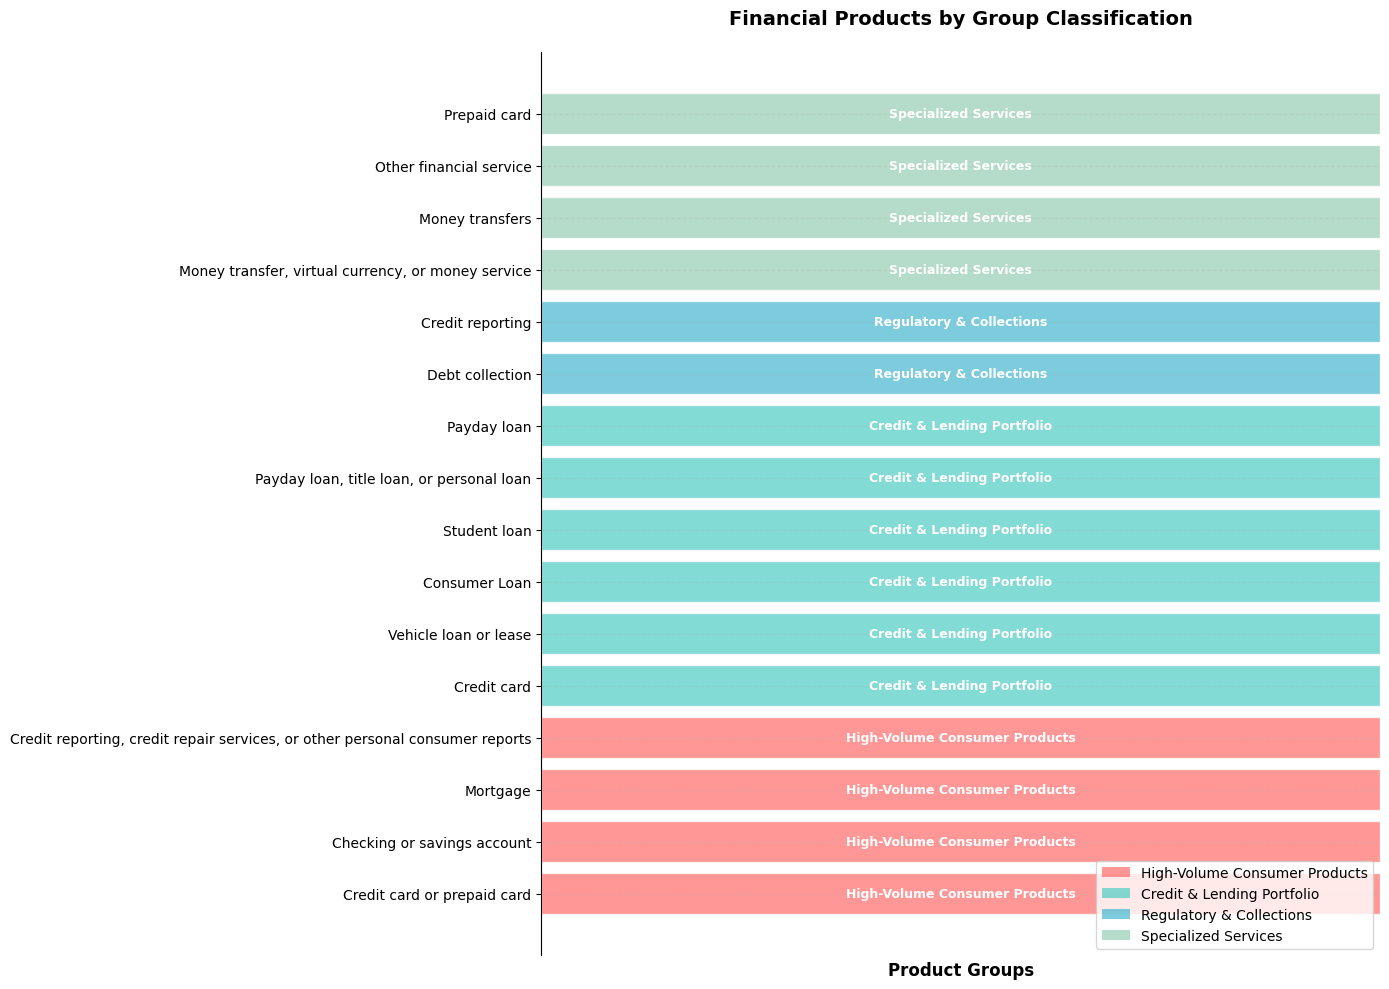

=== PRODUCT GROUPINGS ===

High-Volume Consumer Products:
  • Credit card or prepaid card
  • Checking or savings account
  • Mortgage
  • Credit reporting, credit repair services, or other personal consumer reports
  Total products: 4

Credit & Lending Portfolio:
  • Credit card
  • Vehicle loan or lease
  • Consumer Loan
  • Student loan
  • Payday loan, title loan, or personal loan
  • Payday loan
  Total products: 6

Regulatory & Collections:
  • Debt collection
  • Credit reporting
  Total products: 2

Specialized Services:
  • Money transfer, virtual currency, or money service
  • Money transfers
  • Other financial service
  • Prepaid card
  Total products: 4


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the dataset
data = {
    'Product_Name': [
        'Credit card or prepaid card', 'Checking or savings account', 'Mortgage',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Credit card', 'Vehicle loan or lease', 'Consumer Loan', 'Student loan',
        'Payday loan, title loan, or personal loan', 'Payday loan', 'Debt collection',
        'Credit reporting', 'Money transfer, virtual currency, or money service',
        'Money transfers', 'Other financial service', 'Prepaid card'
    ],
    'Group_Name': [
        'High-Volume Consumer Products', 'High-Volume Consumer Products', 'High-Volume Consumer Products',
        'High-Volume Consumer Products', 'Credit & Lending Portfolio', 'Credit & Lending Portfolio',
        'Credit & Lending Portfolio', 'Credit & Lending Portfolio', 'Credit & Lending Portfolio',
        'Credit & Lending Portfolio', 'Regulatory & Collections', 'Regulatory & Collections',
        'Specialized Services', 'Specialized Services', 'Specialized Services', 'Specialized Services'
    ]
}

df = pd.DataFrame(data)

# Create a clean horizontal bar chart showing product-group relationships
fig, ax = plt.subplots(figsize=(14, 10))

# Get unique groups and assign colors
groups = df['Group_Name'].unique()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
group_colors = dict(zip(groups, colors))

# Create bars with colors based on group
y_positions = range(len(df))
bar_colors = [group_colors[group] for group in df['Group_Name']]

bars = ax.barh(y_positions, [1] * len(df), color=bar_colors, alpha=0.7, edgecolor='white', linewidth=1)

# Set labels
ax.set_yticks(y_positions)
ax.set_yticklabels(df['Product_Name'], fontsize=10)
ax.set_xlabel('Product Groups', fontsize=12, fontweight='bold')
ax.set_title('Financial Products by Group Classification', fontsize=14, fontweight='bold', pad=20)

# Remove x-axis ticks and labels since we just want to show grouping
ax.set_xticks([])
ax.set_xlim(0, 1)

# Add group labels on the bars
for i, (bar, group) in enumerate(zip(bars, df['Group_Name'])):
    ax.text(0.5, bar.get_y() + bar.get_height()/2, group,
            ha='center', va='center', fontweight='bold', fontsize=9, color='white')

# Create legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.7, label=group)
                  for group, color in group_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0))

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Remove spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary of groupings
print("=== PRODUCT GROUPINGS ===")
for group in groups:
    products = df[df['Group_Name'] == group]['Product_Name'].tolist()
    print(f"\n{group}:")
    for product in products:
        print(f"  • {product}")
    print(f"  Total products: {len(products)}")